In [123]:
import torch
import pickle
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
attn_maps = None
with open("trial.pickle", 'rb') as file:
    attn_maps = pickle.load(file)

In [23]:
num_docs = len(attn_maps)
tok = BertTokenizer.from_pretrained('bert-base-uncased')
num_layers, num_heads, seq_len, _ = attn_maps[0]['attention_map'].size()

In [126]:
def get_points(matrix):
    num_layers, num_heads = matrix.size()
    layer_num, head_values, average_across_layer = [],[],[]
    for layer in range(num_layers):
        for head in range(num_heads):
            head_values.append(matrix[layer,head])
            layer_num.append(1+layer)
            
        average_across_layer.append(matrix[layer,:].mean(dim = -1))
        
        
    return layer_num, head_values, average_across_layer

In [127]:
def plot_averages(matrix,ax, label, head_color, avg_color):
    xs, ys, averages = get_points(matrix)
    ax.scatter(xs, ys, label = label, color = head_color)
    
    ax.plot(1+ np.arange(len(averages)), averages, color = avg_color)
    ax.legend(loc = "best")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Average attention")

## Self-Self attention
First, we'll try to calculate how much the words pay attention to themselves. Each attention map is of shape (num_layers, num_heads, seq_len, seq_len). (i,j,k,l) index of attention_map tells us how much attention did k_th token paid to l_th token in i'th layer and j'th attention head.

In [129]:
self_self = torch.zeros(num_layers, num_heads)
for attn_map in attn_maps:
    self_self += torch.diagonal(attn_map['attention_map'], dim1 = -2, dim2 = -1).sum(-1).detach().numpy()/(seq_len*num_docs)

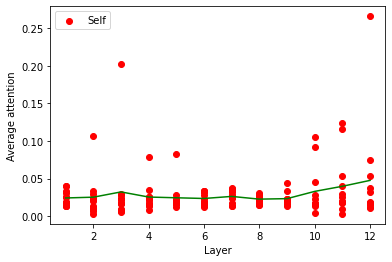

In [132]:
# plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)

plot_averages(self_self, ax, "Self", head_color= 'red', avg_color= 'green')

## Right attention

Now, we'll calculate how much attention words pay to their right words on average

In [131]:
right = torch.zeros(num_layers, num_layers)
for attn_map in attn_maps:
    right += torch.diagonal(attn_map['attention_map'], offset = 1,  dim1 = -2, dim2 = -1).sum(-1).detach().numpy()/(seq_len*num_docs)

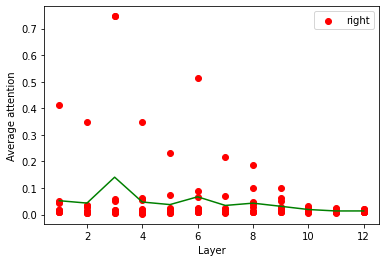

In [134]:
# plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)
plot_averages(right, ax, "right", head_color= 'red', avg_color= 'green')

## Left attention

In [139]:
left = torch.zeros(num_layers, num_layers)
for attn_map in attn_maps:
    left += torch.diagonal(attn_map['attention_map'], offset = -1,  dim1 = -2, dim2 = -1).sum(-1).detach().numpy()/(seq_len*num_docs)

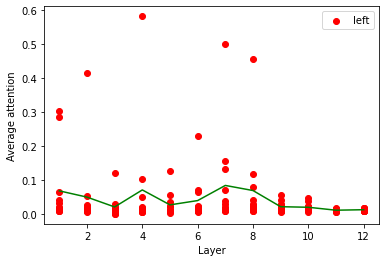

In [140]:
# plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)

plot_averages(left, ax, "left", head_color= 'red', avg_color= 'green')

## [SEP] attention
How much the tokens attend to the [SEP] tokens

In [141]:
sep = torch.zeros(num_layers, num_layers)
for attn_map in attn_maps:
    mask = (attn_map['ids'] == tok.sep_token_id)
    sep += attn_map['attention_map'].masked_fill(~mask, 0).sum(-1).sum(-1).detach().numpy()/(num_docs*seq_len)

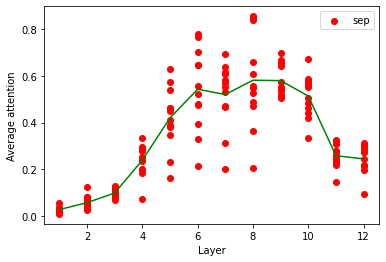

In [143]:
# plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)

plot_averages(sep, ax, "sep", head_color= 'red', avg_color= 'green')

## [SEP]-[SEP] attention

How much the [SEP] token in the middle of two segments attend to end of sentence [SEP] token and vice-versa

In [144]:
sep_sep = torch.zeros(num_layers,num_layers)
for attn_map in attn_maps:
    mask1 = (attn_map['ids'] == tok.sep_token_id)[None,None,None,:] #mask along the row
    mask2 = (attn_map['ids'] == tok.sep_token_id)[None,None,:,None] #mask along the column
    
    sep_sep += attn_map['attention_map'].masked_fill(~mask1, 0).masked_fill(~mask2,0).sum(-1).sum(-1).detach().numpy()/(num_docs*2)

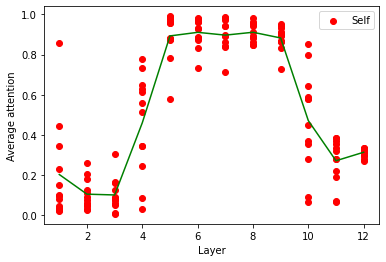

In [145]:
ax = plt.subplot(1,1,1)
plot_averages(sep_sep, ax, "Self", head_color= 'red', avg_color= 'green')

## Rest-[SEP] attention

How much the rest of the tokens pay attention to [SEP] token

In [148]:
rest_sep = torch.zeros(num_layers,num_layers)
for attn_map in attn_maps:
    mask1 = (attn_map['ids'] == tok.sep_token_id)[None,None,None,:] #mask along the row
    mask2 = (attn_map['ids'] == tok.sep_token_id)[None,None,:,None] #mask along the column
    
    rest_sep += attn_map['attention_map'].masked_fill(~mask1, 0).masked_fill(mask2,0).sum(-1).sum(-1).detach().numpy()/(num_docs*(seq_len-2))

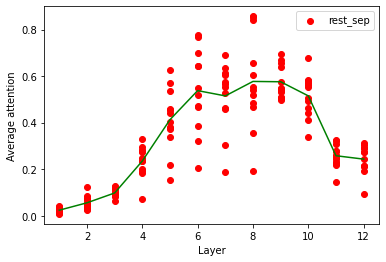

In [157]:
ax = plt.subplot(1,1,1)
plot_averages(rest_sep, ax, "rest_sep", head_color= 'red', avg_color= 'green')

## [CLS] attention

How much all the tokens attend to [CLS] token at the beginning of the sentence

In [152]:
clsa = torch.zeros(num_layers,num_layers)
for attn_map in attn_maps:
    clsa += attn_map['attention_map'][:,:,:,0].sum(-1).detach().numpy()/(num_docs*seq_len)

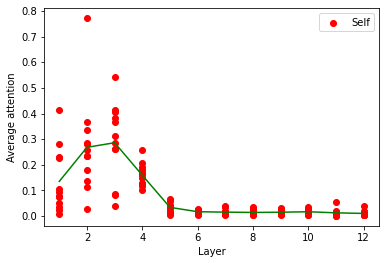

In [153]:
ax = plt.subplot(1,1,1)
plot_averages(clsa, ax, "Self", head_color= 'red', avg_color= 'green')

## Punct attention

Amount of attention all the tokens pay to punctuation tokens on average.

In [155]:
punct = torch.zeros(num_layers, num_layers)
for attn_map in attn_maps:
    mask = torch.tensor([0 if token == ',' or token == '.' else 1 for token in attn_map['tokens']])
    
    punct += attn_map['attention_map'].masked_fill(mask, 0).sum(-1).sum(-1).detach().numpy()/(num_docs*seq_len)
    

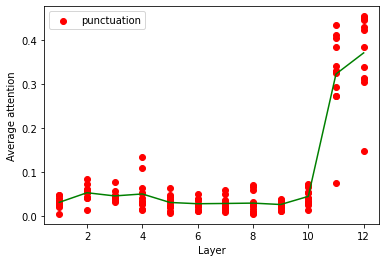

In [156]:
ax = plt.subplot(1,1,1)
plot_averages(punct, ax, "punctuation", head_color= 'red', avg_color= 'green')

## Attention distribution of a random sample

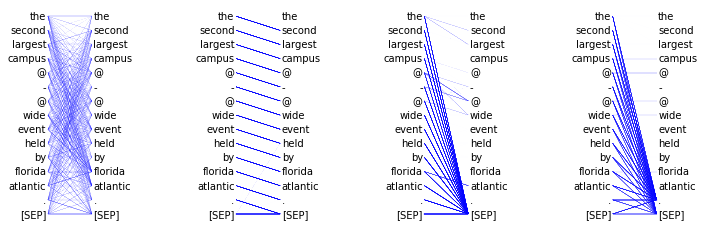

In [221]:
def plot_attn(attn_map, layers, heads, num_words):
    assert len(layers) == len(heads)
    xoffset = 1
    seperation = 4
    width = 3
    yoffset = 1
    pad = 0.1
    word_height = 1
    for i, (layer,head) in enumerate(zip(layers, heads)):
        xoffset = i*width*seperation
        
        words = attn_map['tokens'][-num_words:]
        attn = attn_map['attention_map'][layer, head, -num_words:, -num_words:].detach().numpy()
        attn = attn/attn.sum(axis = -1, keepdims = True)
        
        
        
        for pos,word in enumerate(words):
            plt.text(xoffset, yoffset - pos*word_height, word, ha = "right", va = "center")
            plt.text(xoffset + width, yoffset - pos*word_height, word, ha = "left", va = "center")

            for i in range(num_words):
              for j in range(num_words):
                plt.plot([xoffset + pad, xoffset + width - pad],
                         [yoffset - word_height * i, yoffset - word_height * j],
                         color="blue", linewidth=0.2, alpha = attn[i,j])

                
plt.figure(figsize = (12,4))                
plt.axis("off")
plot_attn(attn_maps[20], [0,2,7,10], [0,0,6,5], num_words = 15)
plt.show()